# Implementar un MLP con PyTorch para clasificación basado en el dataset de agresividad

<img src="figs/fig-MLP_XOR.png" width="50%">


1. **Definir los preprocesamientos para el texto**:  
   - convertir a minúsculas
   - normalizar el texto: borrar símbolos, puntuación, caracteres duplicados, etc.

2. **Separar los datos para entrenamiento y prueba**:  
   - Crear los dataset de entrenamiento y test con al función train_test_split 

3. **Construir la matriz de Documento-Término**:  
   - Definir los parámetros para usar unigramas
   - Usar la clase TfidfVectorizer para construir la matriz con los datos de entrenamiento

   
4. **Preparar los lotes de datos (minibatches) para el entrenamiento de la red**:  
   - Definir los minibatches con la matriz TFIDF construida

5. **Definir la arquitectura de la red**:  
   - Definir entradas, salidas,  capas de la red y funciones de activación

6. **Entrenar el modelo**:  
   - Definir los parámetros de las red como: número de épocas, learning_rate, número de neuronas para las capas ocultas, etc.
   
7. **Evaluar el modelo**:  
   - Después del entrenamiento, probar la red con las entradas del conjunto de test y evaluar el desempeño con las métricas: Precisión, Recall, F1-score o F1-Measure y Accuracy.
   


In [1]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

_STOPWORDS = stopwords.words("spanish")  # agregar más palabras a esta lista si es necesario

# Normalización del texto

import unicodedata
import re
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
NUMBERS= "0123456789"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normaliza_texto(input_str,
                    punct=False,
                    accents=False,
                    num=False,
                    max_dup=2):
    """
        punct=False (elimina la puntuación, True deja intacta la puntuación)
        accents=False (elimina los acentos, True deja intactos los acentos)
        num= False (elimina los números, True deja intactos los acentos)
        max_dup=2 (número máximo de símbolos duplicados de forma consecutiva, rrrrr => rr)
    """
    
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not num:
            if c in NUMBERS:
                continue
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    texto = unicodedata.normalize('NFKD', "".join(n_str))
    texto = re.sub(r'(\s)+', r' ', texto.strip(), flags=re.IGNORECASE)
    return texto


# Preprocesamiento personalizado 
def mi_preprocesamiento(texto):
    #convierte a minúsculas el texto antes de normalizar
    tokens = word_tokenize(texto.lower())
    texto = " ".join(tokens)
    texto = normaliza_texto(texto)
    return texto
    
# Tokenizador personalizado 
def mi_tokenizador(texto):
    # Elimina stopwords: palabras que no se consideran de contenido y que no agregan valor semántico al texto
    #print("antes: ", texto)
    texto = [t for t in texto.split() if t not in _STOPWORDS]
    #print("después:",texto)
    return texto

# Definición de los datos y minibatches

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder



# colocar la semilla para la generación de números aleatorios para la reproducibilidad de experimentos
random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)

# Cargar los datos de agresividad y separa los documentos (X) y las clases (Y)
dataset = pd.read_json("./data_aggressiveness_es.json", lines=True)
print(dataset.klass.value_counts()) # muestra el conteo de cada clase
# Extracción de los textos en arreglos de numpy
X = dataset['text'].to_numpy()
# Extracción de las etiquetas o clases de entrenamiento
Y = dataset['klass'].to_numpy()




klass
nonaggressive    3655
aggressive       1477
Name: count, dtype: int64


In [45]:
# TODO: Codificar las etiquetas de los datos a una forma categórica numérica: LabelEncoder.
le = LabelEncoder()
Y_encoded= le.fit_transform(Y)# Normalizar las etiquetas a una codificación ordinal para entrada del clasificador
print(Y_encoded)
Y_encoded = Y_encoded[:, np.newaxis] #Agregar una dimensión extra para que sea compatible con PyTorch
print(Y_encoded)

[0 1 1 ... 1 0 1]
[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]


In [ ]:


# TODO: Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de pruebas (20%)
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de pruebas:", X_test.shape)




Tamaño del conjunto de entrenamiento: (4105,)
Tamaño del conjunto de pruebas: (1027,)


In [46]:
# TODO: Crear la matriz Documento-Término con el dataset de entrenamiento: tfidfVectorizer
vec_tfidf = TfidfVectorizer(
    analyzer="word", preprocessor=mi_preprocesamiento, tokenizer=mi_tokenizador, ngram_range=(1,1)
)

#Entrenar vectorizador con el conjunto de entrenamiento
X_train_tfidf = vec_tfidf.fit_transform(X_train)

#Transformar el conjunto de prueba usando el mismo vocabulario
X_test_tfidf = vec_tfidf.transform(X_test)

c:\Users\edwar\miniconda3\envs\RNA\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [47]:

# Crear minibatches en PyTorch usando DataLoader
def create_minibatches(X, Y, batch_size):
    # Recibe los documentos en X y las etiquetas en Y
    dataset = TensorDataset(X, Y) # Cargar los datos en un dataset de tensores
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


# Definición de la arquitectura de la red

In [48]:

# Definir la red neuronal en PyTorch heredando de la clase base de Redes Neuronales: Module
class MLP(nn.Module):
    # Definir los parámetros para la creación de la clase MLP
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # TODO: Definición de capas, funciones de activación e inicialización de pesos
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias) 

    def forward(self, X):
        # Definición del orden de conexión de las capas y aplición de las funciones de activación
        # TODO: DEFINIR EL ORDEN DE LAS CAPAS Y FUNCIONES DE ACTIVACIÓN
        out = self.fc1(X)
        out = self.sigmoid(out)  # Aplicamos la sigmoide en la capa oculta
        out = self.fc2(out)
        out = self.sigmoid(out)  # Aplicamos la sigmoide en la capa de salida
        return out

In [84]:

# Definir la red neuronal en PyTorch heredando de la clase base de Redes Neuronales: Module
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Definición de capas, funciones de activación e inicialización de pesos
        #AQUI PODEMOSS HACER UNA LIUSTA DE CAPAS INTERMEDIAS Y GUARDARLAS EN UNA LISTA.
        #capas_intermedias.append(nn.Linear(1000,128 ))
        #capas_intermedias.append(nn.Linear(128,64 ))
        #capas_intermedias.append(nn.Linear(64,1 ))
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fcExt = nn.Linear(hidden_size, 32 )
        self.fc2 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fcExt.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc1.bias is not None:
            nn.init.zeros_(self.fcExt.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias)        

    
    def forward(self, X):
        # Definición del orden de conexión de las capas y aplición de las funciones de activación
        out = self.fc1(X)
        out = self.sigmoid(out)  # Aplicamos la sigmoide en la capa oculta
        out = self.fcExt(out)
        out = self.sigmoid(out)  # Aplicamos la sigmoide en la capa oculta
        out = self.fc2(out)
        out = self.sigmoid(out)  # Aplicamos la sigmoide en la capa de salida
        return out

# Entrenamiento de la red

In [86]:

# TODO: Convertir los datos de entrenamiento y etiquetas a tensores  de PyTorch
X_train = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Establecer los parámetros de la red

# Parámetros de la red
input_size = X_train.shape[1] #Aqui se define el tamaño de entrada basado en la matriz TFIDF
hidden_size = 64 # --> ? 
output_size = 1  # La salida es el resultado de la sigmoide para un clasificador 
                 # binario: 0 o 1
epochs = 500    # variar el número de épocas, para probar que funciona la programación 
                 # solo usar 2 épocas, para entrenamiento total usar por ejemplo 1000 épocas
learning_rate = 0.1   # Generalmente se usan learning rate pequeños entre [0,1] como (0.1, 0.3), 
                      #

# Se recomiendan tamaños de batch_size potencias de 2: 16, 32, 64, 128, 256
# Entre mayor el número más cantidad de memoria se requiere para el procesamiento
batch_size = 32 # definir el tamaño del lote de procesamiento 

# Crear el modelo de la red 
# TODO: Ajustar los parámetros de acuerdo a su definición particular
model = MLP(input_size, hidden_size, output_size)

# TODO: Definir la función de pérdida
# Mean Square Error (MSE)
criterion = nn.MSELoss()

# Definir el optimizador
# Parámetros del optimizador: parámetros del modelo y learning rate 
# Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


C:\Users\edwar\AppData\Local\Temp\ipykernel_13324\1152278739.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
C:\Users\edwar\AppData\Local\Temp\ipykernel_13324\1152278739.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)


In [87]:

# Entrenamiento
print("Iniciando entrenamiento en PyTorch")

# Poner el modelo en modo de entrenamiento
model.train()  

for epoch in range(epochs):
    lossTotal = 0
    #definir el batch_size
    dataloader = create_minibatches(X_train, Y_train, batch_size=batch_size)
    for X_tr, y_tr in dataloader:
        
        # TODO: Inicializar los gradientes en cero para cada época
        optimizer.zero_grad()

        
        # TODO: Propagación hacia adelante
        # invoca al método forward de la clase MLP con los datos de entrenamiento
        y_pred =  model(X_tr)
        
        # Calcular el error MSE, de acuerdo a lo predicho (y_pred)  y la clase objetivo (y)
        loss = criterion(y_pred, y_tr)
        
        # TODO: Acumular el error 
        lossTotal += loss.item()
        
        # TODO: Propagación hacia atrás: cálculo de los gradientes de los pesos y bias
        loss.backward()
        
        # TODO: Actualización de los pesos: regla de actualización basado en el gradiente:
        # Regla delta:  W = W - learning_rate * dE/dW
        optimizer.step()

    print(f"Época {epoch+1}/{epochs}, Pérdida: {lossTotal/len(dataloader)}")


Iniciando entrenamiento en PyTorch
Época 1/500, Pérdida: 0.21036820870268252
Época 2/500, Pérdida: 0.20555176453072896
Época 3/500, Pérdida: 0.206590351092723
Época 4/500, Pérdida: 0.20517626664666241
Época 5/500, Pérdida: 0.20495725509732268
Época 6/500, Pérdida: 0.20495351086291233
Época 7/500, Pérdida: 0.20547803191020508
Época 8/500, Pérdida: 0.20504393890615583
Época 9/500, Pérdida: 0.20487466541140578
Época 10/500, Pérdida: 0.20562935014103734
Época 11/500, Pérdida: 0.2052052412615266
Época 12/500, Pérdida: 0.20590917766094208
Época 13/500, Pérdida: 0.20505262582108033
Época 14/500, Pérdida: 0.2057738792180091
Época 15/500, Pérdida: 0.20511709812075593
Época 16/500, Pérdida: 0.20501304718182067
Época 17/500, Pérdida: 0.2050035379884779
Época 18/500, Pérdida: 0.2057142594988032
Época 19/500, Pérdida: 0.2054660220940908
Época 20/500, Pérdida: 0.20580914778302806
Época 21/500, Pérdida: 0.20483312155156172
Época 22/500, Pérdida: 0.20542792571607485
Época 23/500, Pérdida: 0.2049914732

### Modo para predicción de datos

In [73]:
model.train()
for epoch in range(epochs):
    lossTotal = 0
    dataloader = create_minibatches(X_train, Y_train, batch_size=batch_size)
    for X_tr, y_tr in dataloader:
        optimizer.zero_grad()
        y_pred = model(X_tr)
        loss = criterion(y_pred, y_tr)
        lossTotal += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Época {epoch+1}/{epochs}, Pérdida: {lossTotal/len(dataloader)}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x10609 and 2x64)

In [88]:

# -----------------------------
# Evaluación / predicción
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

y_pred_final = torch.where(y_pred_test >= 0.5, 1, 0)

print("Predicciones binarias:")
print(y_pred_final)

Predicciones binarias:
tensor([[0],
        [1],
        [1],
        ...,
        [0],
        [1],
        [0]])


### Evaluación

[[189 107]
 [ 83 648]]
              precision    recall  f1-score   support

         0.0     0.6949    0.6385    0.6655       296
         1.0     0.8583    0.8865    0.8721       731

    accuracy                         0.8150      1027
   macro avg     0.7766    0.7625    0.7688      1027
weighted avg     0.8112    0.8150    0.8126      1027



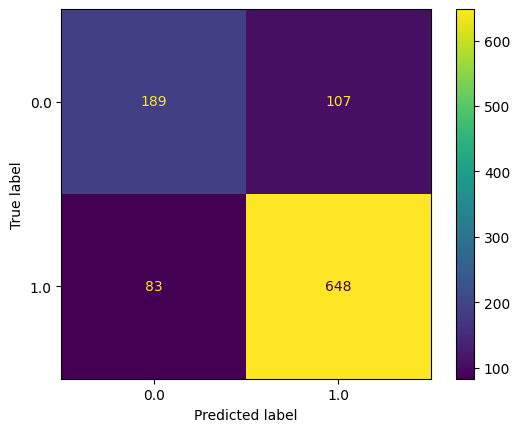

In [89]:
# TODO: Evaluar el modelo con las predicciones obtenidas y las etiquetas esperadas: 
# classification_report y  matriz de confusión (métricas Precisión, Recall, F1-measaure, Accuracy)
# Convertir tensores PyTorch a numpy para usar con sklearn
y_true = Y_test.numpy()
y_pred_test = y_pred_final.numpy()
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_test)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, y_pred_test))
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_test, digits=4, zero_division='warn'))



In [70]:
le.inverse_transform([0, 1])

array(['aggressive', 'nonaggressive'], dtype=object)

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# -----------------------------
# 🔹 Semillas para reproducibilidad
# -----------------------------
random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)

# -----------------------------
# 🔹 Cargar dataset
# -----------------------------
dataset = pd.read_json("./data_aggressiveness_es.json", lines=True)
print(dataset.klass.value_counts())

X = dataset['text'].to_numpy()
Y = dataset['klass'].to_numpy()

# -----------------------------
# 🔹 Codificar etiquetas a números
# -----------------------------
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)
Y_encoded = Y_encoded[:, np.newaxis]  # agregar dimensión extra para PyTorch

# -----------------------------
# 🔹 Dividir datos en entrenamiento y prueba
# -----------------------------
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=42
)
print("Tamaño del entrenamiento:", X_train.shape)
print("Tamaño del test:", X_test.shape)

# -----------------------------
# 🔹 Vectorización TF-IDF
# Importante: entrenar solo con X_train
# -----------------------------
vec_tfidf = TfidfVectorizer(
    analyzer="word", preprocessor=mi_preprocesamiento, tokenizer=mi_tokenizador, ngram_range=(1,1)
)

# 🔹 Entrenar vectorizador con el conjunto de entrenamiento
X_train_tfidf = vec_tfidf.fit_transform(X_train)

# 🔹 Transformar el conjunto de prueba usando el mismo vocabulario
X_test_tfidf = vec_tfidf.transform(X_test)

print("Dimensiones TF-IDF entrenamiento:", X_train_tfidf.shape)
print("Dimensiones TF-IDF prueba:", X_test_tfidf.shape)

# -----------------------------
# 🔹 Crear tensores PyTorch
# -----------------------------
X_train = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# -----------------------------
# 🔹 Función para crear minibatches
# -----------------------------
def create_minibatches(X, Y, batch_size):
    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# -----------------------------
# 🔹 Definir la red neuronal
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias) 

    def forward(self, X):
        out = self.fc1(X)
        out = self.sigmoid(out)  # capa oculta
        out = self.fc2(out)
        out = self.sigmoid(out)  # capa de salida
        return out

# -----------------------------
# 🔹 Parámetros de la red
# -----------------------------
input_size = X_train.shape[1]  # tamaño de la entrada = número de características TF-IDF
hidden_size = 10               # puedes ajustar
output_size = 1
epochs = 100
learning_rate = 0.2
batch_size = 32

# -----------------------------
# 🔹 Crear modelo, criterio y optimizador
# -----------------------------
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# -----------------------------
# 🔹 Entrenamiento
# -----------------------------
model.train()
for epoch in range(epochs):
    lossTotal = 0
    dataloader = create_minibatches(X_train, Y_train, batch_size=batch_size)
    for X_tr, y_tr in dataloader:
        optimizer.zero_grad()
        y_pred = model(X_tr)
        loss = criterion(y_pred, y_tr)
        lossTotal += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Época {epoch+1}/{epochs}, Pérdida: {lossTotal/len(dataloader)}")

# -----------------------------
# 🔹 Evaluación / predicción
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

y_pred_final = torch.where(y_pred_test >= 0.5, 1, 0)

print("Predicciones binarias:")
print(y_pred_final)


klass
nonaggressive    3655
aggressive       1477
Name: count, dtype: int64
Tamaño del entrenamiento: (4105,)
Tamaño del test: (1027,)


c:\Users\edwar\miniconda3\envs\RNA\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Dimensiones TF-IDF entrenamiento: (4105, 10609)
Dimensiones TF-IDF prueba: (1027, 10609)
Época 1/100, Pérdida: 0.20580342053905015
Época 2/100, Pérdida: 0.20484161989171376
Época 3/100, Pérdida: 0.20465088808952375
Época 4/100, Pérdida: 0.2049386042148568
Época 5/100, Pérdida: 0.20435842825460804
Época 6/100, Pérdida: 0.20462141422800315
Época 7/100, Pérdida: 0.20371243455844332
Época 8/100, Pérdida: 0.2040328115455864
Época 9/100, Pérdida: 0.20353337313777717
Época 10/100, Pérdida: 0.20391448003839152
Época 11/100, Pérdida: 0.203110803236333
Época 12/100, Pérdida: 0.2026834396659866
Época 13/100, Pérdida: 0.20232452856477842
Época 14/100, Pérdida: 0.20230802853209104
Época 15/100, Pérdida: 0.20206304500962413
Época 16/100, Pérdida: 0.20245230151701343
Época 17/100, Pérdida: 0.2022572436998057
Época 18/100, Pérdida: 0.2006153842044431
Época 19/100, Pérdida: 0.20124588773925176
Época 20/100, Pérdida: 0.2007592695281487
Época 21/100, Pérdida: 0.19980791436378345
Época 22/100, Pérdida: 0.

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convertir tensores PyTorch a numpy para usar con sklearn
y_true = Y_test.numpy()
y_pred = y_pred_final.numpy()

# 🔹 Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusión:")
print(cm)

# 🔹 Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# 🔹 Reporte de clasificación
report = classification_report(y_true, y_pred, target_names=le.classes_)
print("Reporte de clasificación:")
print(report)


Matriz de confusión:
[[137 159]
 [ 24 707]]
Accuracy: 0.8218
Reporte de clasificación:
               precision    recall  f1-score   support

   aggressive       0.85      0.46      0.60       296
nonaggressive       0.82      0.97      0.89       731

     accuracy                           0.82      1027
    macro avg       0.83      0.72      0.74      1027
 weighted avg       0.83      0.82      0.80      1027

